In [5]:
# necessary: netcdf4-python, regionmask, (xarray, geopandas), cartopy, openpyxl, (statsmodels?)

import numpy as np
import pandas as pd
import os, glob, re 
import math
import xarray as xr
import geopandas as gpd
import regionmask as regionmask
import dask
import matplotlib.pyplot as plt
import netCDF4

%matplotlib inline

#plotting
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# import my variables settings functions from other scripts
from settings_ana import *

# import fxns 
from functions_ana import *
from utils_ana import *
from plotscript import *

# import other packages/modules 

sys.path.append('../population/') # make this a module i can pip install and import ! 
from population_demographics_climate import * # move / rename this when good ! --> change to import demographics4climate as d4c


In [6]:
from dask.distributed import Client 
client = Client()
client

/apps/brussel/RL8/zen4/software/dask/2023.9.2-foss-2023a/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40419 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:40419/status,
Dashboard: http://127.0.0.1:40419/status,Workers: 2
Total threads: 2,Total memory: 60.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38555,Workers: 2
Dashboard: http://127.0.0.1:40419/status,Total threads: 2
Started: Just now,Total memory: 60.00 GiB
Comm: tcp://127.0.0.1:33995,Total threads: 1
Dashboard: http://127.0.0.1:37611/status,Memory: 30.00 GiB
Nanny: tcp://127.0.0.1:45171,


In [7]:
start_message() # change indir to indir obs and datasets to datasets obs in start message

flags: {'models': 'ISIMIP3b', 'experiment': None, 'metric': 'WBGT28', 'method': None, 'time_method': None, 'shift_sigma': False, 'shift_period': None, 'shift_loglike': None, 'chunk_version': None, 'var': 'wbgt'}
var: wbgt
VARs: None
indir_p: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/InputData/climate/atmosphere/bias-adjusted/global/daily/
indir_s: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/SecondaryInputData/climate/atmosphere/bias-adjusted/global/daily/
indir_obs: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3a/InputData/climate/atmosphere/obsclim/global/daily/historical/
indir_counterclim: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3a/InputData/climate/atmosphere/counterclim/global/daily/historical/
GCMs: ['CanESM5', 'CNRM-CM6-1', 'GFDL-ESM4', 'IPSL-CM6A-LR', 'MIROC6', 'MRI-ESM2-0']
datasets: ['GSWP3-W5E5', '20CRv3-ERA5', '20CRv3-W5E5']
lat_chunk: 90
lon_chunk: 120
time_chunk: -1
outdirs: /data/brussel/vo/000/bvo00012/vsc10419/

In [8]:
# add to settings ! 
cellarea = xr.open_dataarray(os.path.join(datadirs,'geo-information/clm45_area.nc4'))

# open nAHD data for WBGT28

In [9]:
metric_script='WBGT28'

In [10]:
dirname='output_empirical' #os.path.join(outdirs, f'output_empirical/{metric_script}') #outdirnames[metric_script]
dirname

'output_empirical'

In [11]:
figdir = os.path.join(figdirs, 'fig_aug24')

if not os.path.exists(figdir):
    os.makedirs(figdir)

In [12]:
get_outdir(GCMs[0],metric=metric_script,outdirname=dirname,models='ISIMIP3b')

'/data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output/output_empirical/WBGT28/ISIMIP3b/CanESM5'

In [13]:
da_p0, da_p1 = open_all_p0_p1(GCMs, metric=metric_script, outdirname=dirname)

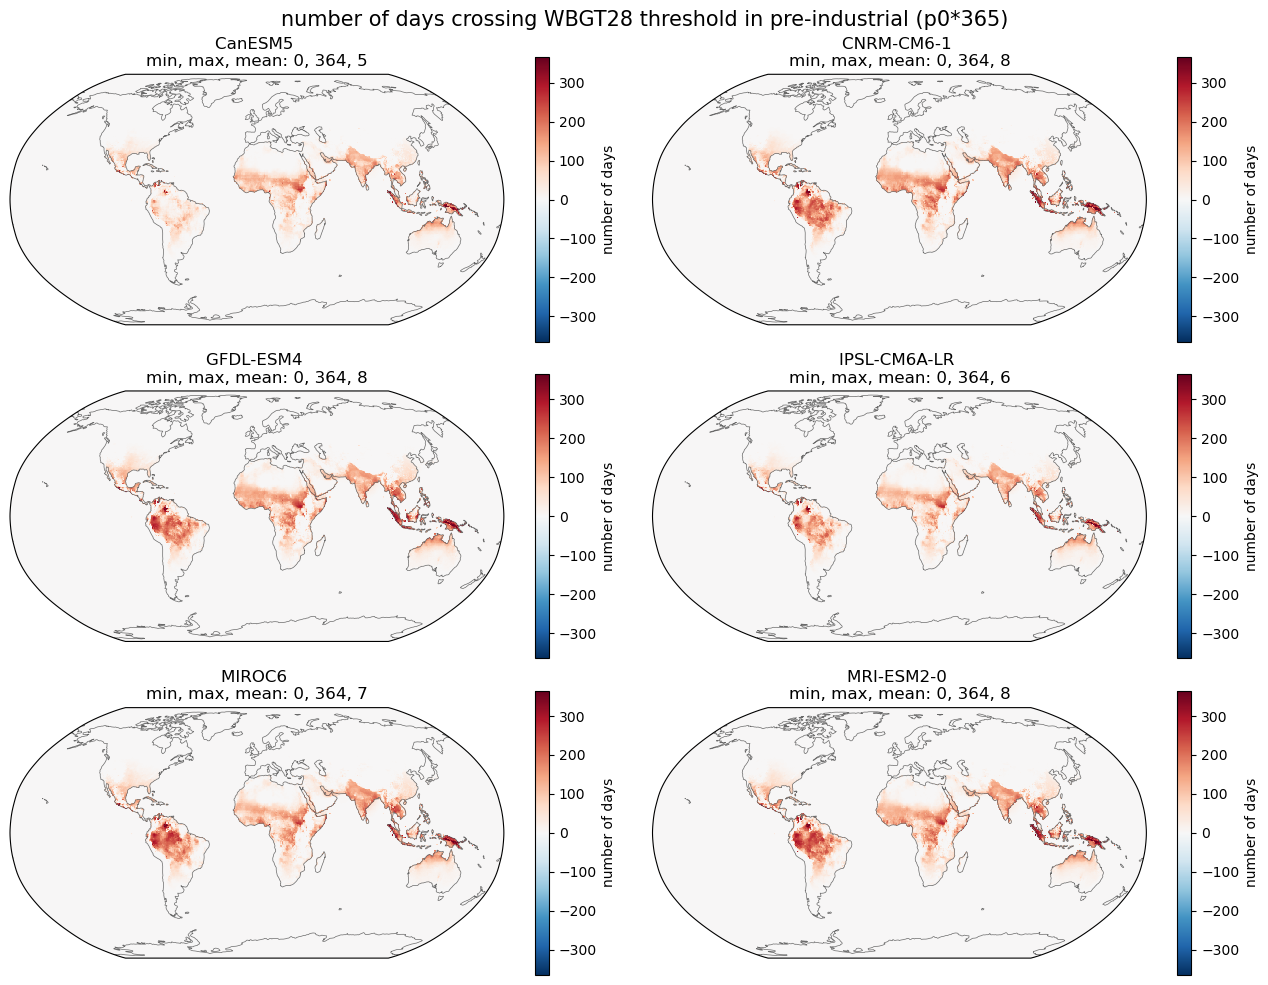

In [12]:
# p0

proj = ccrs.Robinson()
landmask = get_mask()
crs = ccrs.PlateCarree()
vmax = 365
levels = np.linspace(-vmax,vmax,num=20)

fig, axes = plt.subplots(3,2,figsize=(13,10), subplot_kw={'projection': proj})
axes = axes.flatten() 

for GCM, ax in zip(GCMs, axes):
    data_plot = (da_p0.sel(model=GCM) *365).rename('number of days') #*landmask
    data_plot.plot(ax=ax, cmap = 'RdBu_r', vmax=vmax, vmin=-vmax, transform=crs )  #extend='max'
    ax.set_title(f'{GCM} \nmin, max, mean: {data_plot.min():.0f}, {data_plot.max():.0f}, {data_plot.mean():.0f}')
    ax.coastlines(color='dimgray', linewidth=0.5)
    #ax.set_label('number of days')
    #ax.add_feature(cfeature.BORDERS, facecolor="none", edgecolor='dimgray', linewidth=0.5 )
    
fig.suptitle(f'number of days crossing {metric_script} threshold in pre-industrial (p0*365)', size=15);
fig.tight_layout()

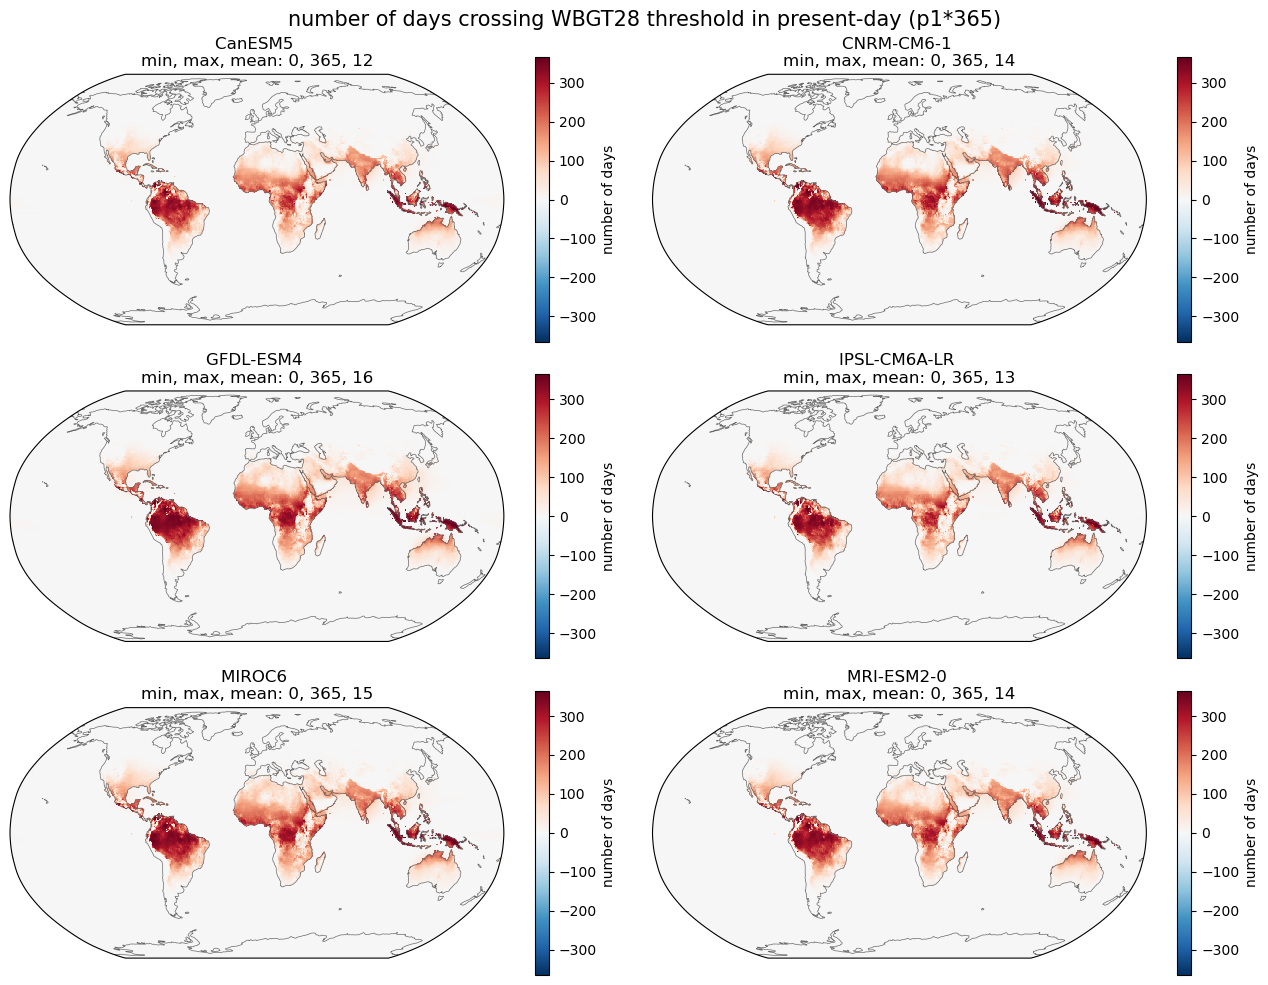

In [13]:
# p1

proj = ccrs.Robinson()
landmask = get_mask()
crs = ccrs.PlateCarree()
vmax = 365
levels = np.linspace(-vmax,vmax,num=20)

fig, axes = plt.subplots(3,2,figsize=(13,10), subplot_kw={'projection': proj})
axes = axes.flatten() 

for GCM, ax in zip(GCMs, axes):
    data_plot = (da_p1.sel(model=GCM) *365).rename('number of days') #*landmask
    data_plot.plot(ax=ax, cmap = 'RdBu_r', vmax=vmax, vmin=-vmax, transform=crs )  #extend='max'
    ax.set_title(f'{GCM} \nmin, max, mean: {data_plot.min():.0f}, {data_plot.max():.0f}, {data_plot.mean():.0f}')
    ax.coastlines(color='dimgray', linewidth=0.5)
    #ax.set_label('number of days')
    #ax.add_feature(cfeature.BORDERS, facecolor="none", edgecolor='dimgray', linewidth=0.5 )
    
fig.suptitle('number of days crossing WBGT28 threshold in present-day (p1*365)', size=15);
fig.tight_layout()

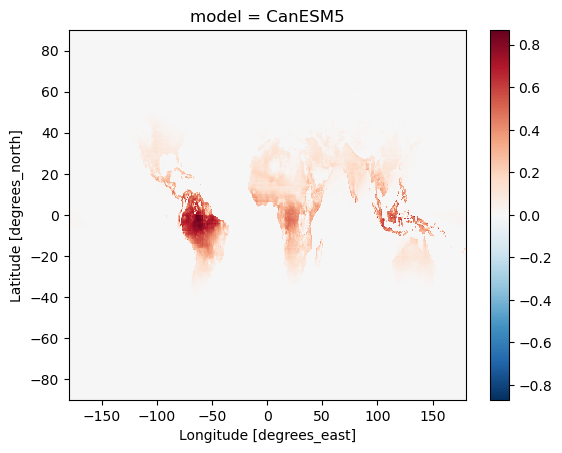

In [14]:
(da_p1.isel(model=0)-da_p0.isel(model=0)).plot() # p1-p0

In [14]:
da_nAHD = open_all_nAHD(GCMs,  metric=metric_script, outdirname=dirname)

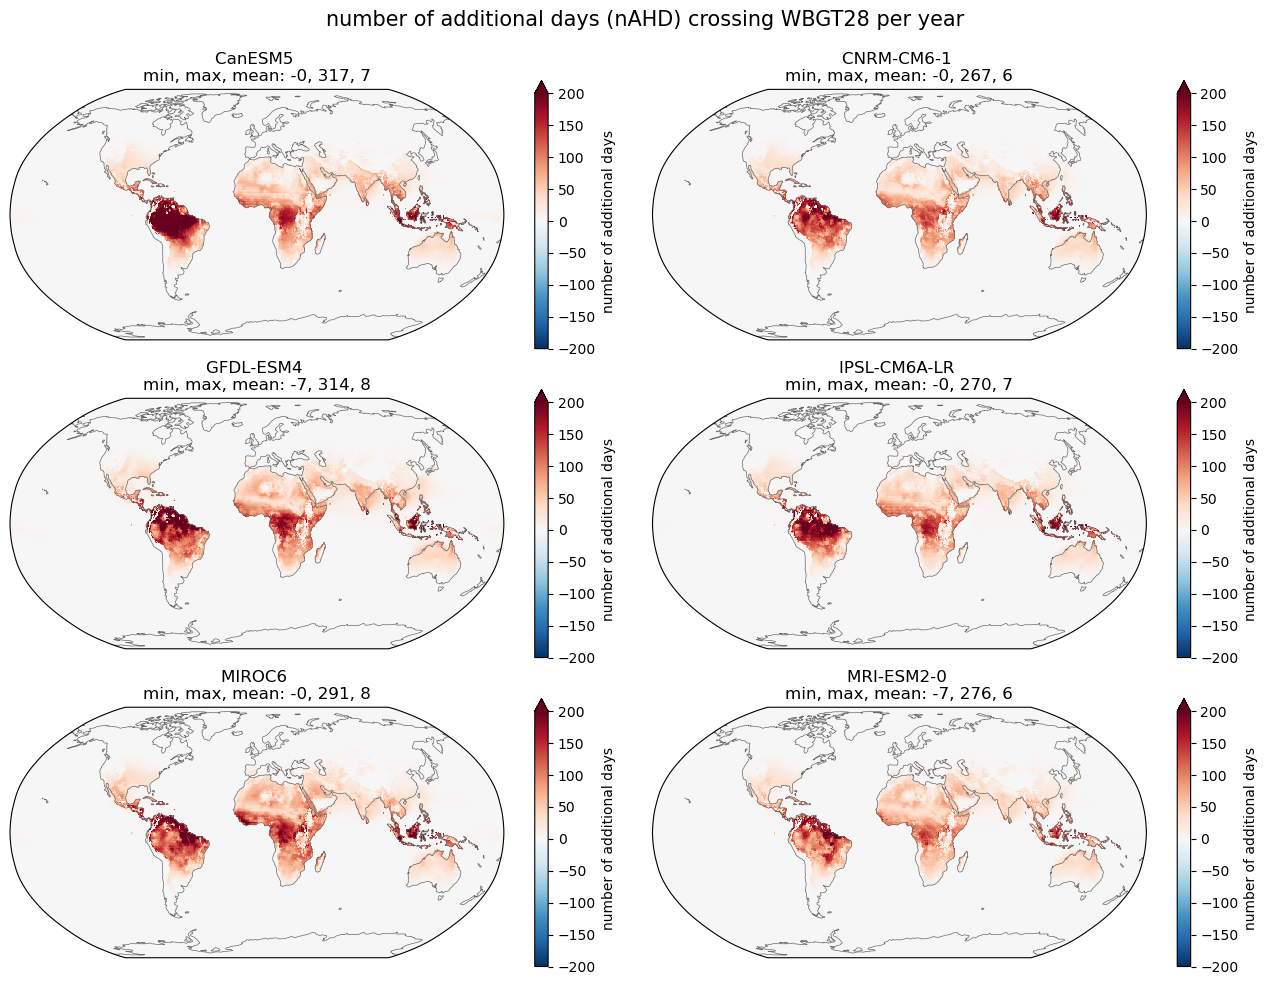

In [16]:
# nAHD

proj = ccrs.Robinson()
landmask = get_mask()
crs = ccrs.PlateCarree()
vmax = 200
levels = np.linspace(-vmax,vmax,num=20)

fig, axes = plt.subplots(3,2,figsize=(13,10), subplot_kw={'projection': proj})
axes = axes.flatten() 

for GCM, ax in zip(GCMs, axes):
    data_plot = da_nAHD.sel(model=GCM) #*landmask
    data_plot.plot(ax=ax, cmap = 'RdBu_r', vmax=vmax, vmin=-vmax, transform=crs, extend='max') 
    ax.set_title(f'{GCM} \nmin, max, mean: {data_plot.min():.0f}, {data_plot.max():.0f}, {data_plot.mean():.0f}')
    ax.coastlines(color='dimgray', linewidth=0.5)
    #ax.add_feature(cfeature.BORDERS, facecolor="none", edgecolor='dimgray', linewidth=0.5 )
    
fig.suptitle(f'number of additional days (nAHD) crossing {metric_script} per year\n', size=15);
fig.tight_layout()

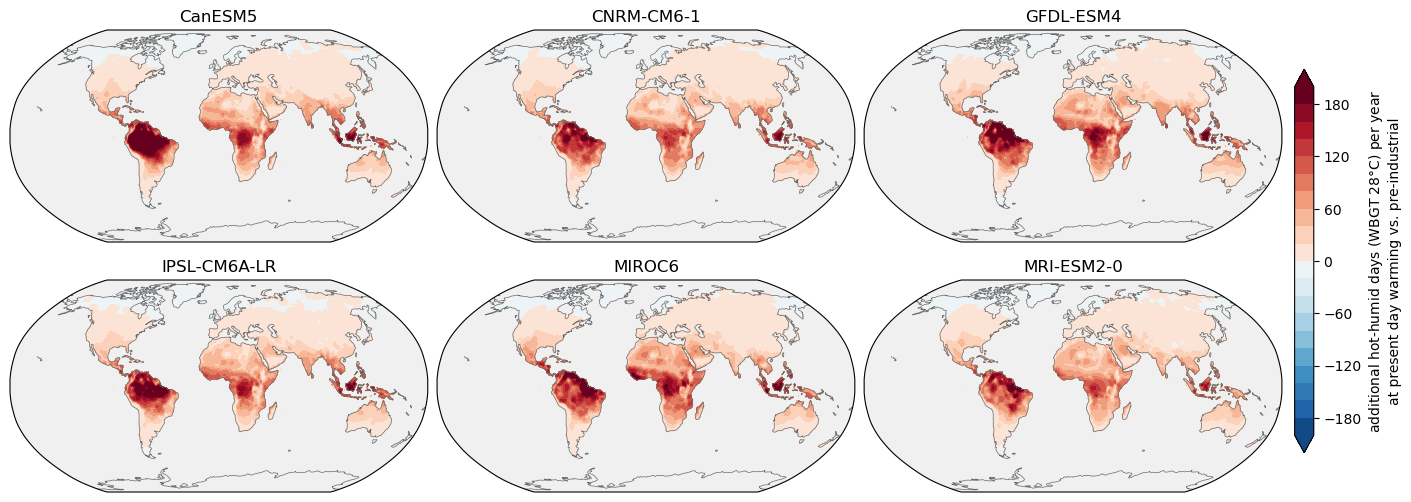

In [26]:

proj = ccrs.Robinson()
landmask = get_mask()
crs = ccrs.PlateCarree()
vmax = 200
vmin = -4 
nlevels=21
mycmap = make_mycmap_nowhite(cmap='RdBu_r', length=nlevels)
whiteonblack = False  
sigma = 1.2
levels = np.linspace(-vmax, vmax, nlevels)
annotate = False

# set colors 
if whiteonblack == True:
    fg_color = 'white'
else:
    fg_color = 'k' 

#plot 
fig, axes = plt.subplots(2,3,figsize=(14,5), subplot_kw={'projection': proj}, layout='constrained')
axes = axes.flatten() 

for GCM, ax in zip(GCMs, axes):
    data = da_nAHD.sel(model=GCM)
    data_plot = gaussian_filter(data, sigma) * landmask # then mask it 
    plot = ax.contourf(data.lon, data.lat, data_plot, vmax=vmax, vmin=-vmax, transform=crs, levels=levels, cmap=mycmap, extend='both') #add_colorbar=False cmap = mycmap, 
    
    #title 
    if annotate == True:
        title = f'{GCM} \nmin, max, mean: {data_plot.min():.0f}, {data_plot.max():.0f}, {data_plot.mean():.0f} \nsum:{data_plot.sum():.2e}'
    else:
        title = f'{GCM}'
    
    ax.set_title(title, color=fg_color) 
    ax.coastlines(color='dimgray', linewidth=0.5)
    ax.set_facecolor('#f0f0f0')
    
    # check
    #plt.colorbar(plot, extend='max',ax=ax)
    
    for spine in plot.axes.spines.values():
        spine.set_edgecolor(fg_color)   
    
cb = fig.colorbar(plot, extend='max', ax=axes, shrink=0.8, location='right', fraction= 0.045, pad= 0.01) # incr pad to increase space figs and cbar

# change colors of stuff for white on black option 
cb.set_label('additional hot-humid days (WBGT 28$\degree$C) per year \nat present day warming vs. pre-industrial', color=fg_color)
cb.ax.yaxis.set_tick_params(color=fg_color)
cb.outline.set_edgecolor(fg_color)
plt.setp(plt.getp(cb.ax.axes, 'yticklabels'), color=fg_color);


# save figure
#plt.savefig(os.path.join(figdir,'nAHD_WBGT28_map_contourf'), dpi=300, transparent=False)


places where in PI it is impossible and no longer impossible in present:

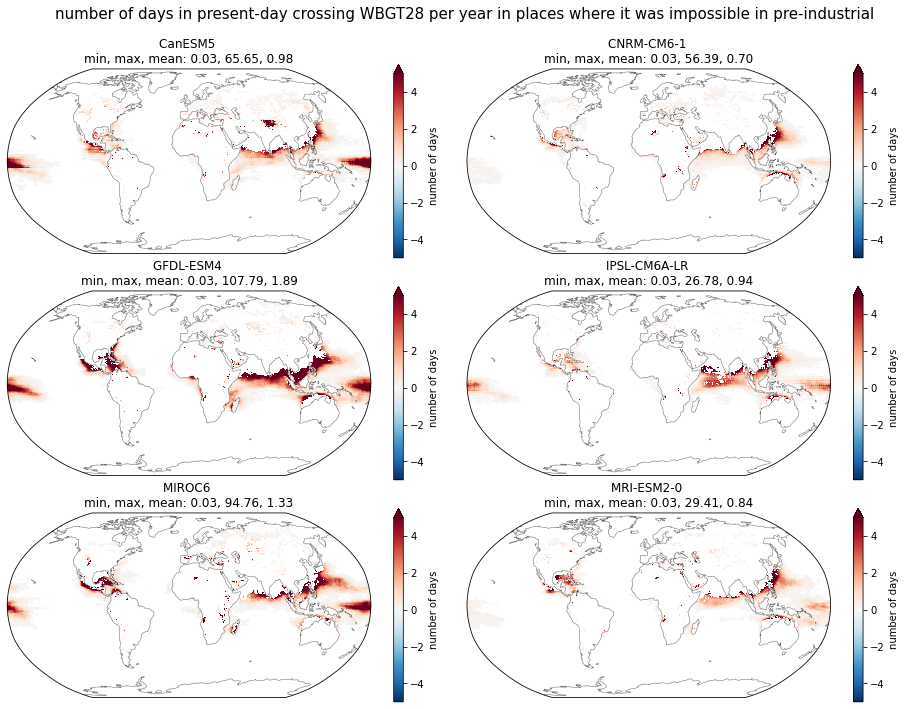

In [14]:
proj = ccrs.Robinson()
landmask = get_mask()
crs = ccrs.PlateCarree()
vmax = 5
levels = np.linspace(-vmax,vmax,num=20)

fig, axes = plt.subplots(3,2,figsize=(13,10), subplot_kw={'projection': proj})
axes = axes.flatten() 

for GCM, ax in zip(GCMs, axes):
    data_plot = (da_p1.where(da_p0 == 0).where(da_p1 !=0 ).sel(model=GCM) *365).rename('number of days') #*landmask
    data_plot.plot(ax=ax, cmap = 'RdBu_r', vmax=vmax, vmin=-vmax, transform=crs, extend='max') 
    ax.set_title(f'{GCM} \nmin, max, mean: {data_plot.min():.2f}, {data_plot.max():.2f}, {data_plot.mean():.2f}')
    ax.coastlines(color='dimgray', linewidth=0.5)
    #ax.add_feature(cfeature.BORDERS, facecolor="none", edgecolor='dimgray', linewidth=0.5 )
    
fig.suptitle(f'number of days in present-day crossing {metric_script} per year in places where it was impossible in pre-industrial\n', size=15);
fig.tight_layout()

## latitudinal bands 

Lower latitudes have higher p0, p1 and nAHD

Only over land areas, what is avg for different latitudinal bands?

Area-weighted average value per land pixellandmask

In [15]:
# Define the latitudinal bands
lat_bins = range(-90, 91, 20)
[i for i in lat_bins]

[-90, -70, -50, -30, -10, 10, 30, 50, 70, 90]

In [16]:
# Group the data into the latitudinal bands and compute the mean for each band
# area weighted average per pixel !

weighted_sum = (da_p0 * landmask * 365 * cellarea).groupby_bins('lat', lat_bins[1:]).sum(dim=['lat','lon']) 
total_area = (cellarea * landmask).groupby_bins('lat', lat_bins[1:]).sum(dim=['lat','lon'])

da_p0_mean_lat = weighted_sum / total_area 
da_p0_mean_lat.to_pandas().T

# older, not weighted version

# da_p0_mean_lat = (da_p0 * landmask * 365).groupby_bins('lat', lat_bins[1:]).mean(dim=['lat','lon']) 
# da_p0_mean_lat.to_pandas().T

model,CanESM5,CNRM-CM6-1,GFDL-ESM4,IPSL-CM6A-LR,MIROC6,MRI-ESM2-0
lat_bins,,,,,,
"(-70, -50]",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"(-50, -30]",2.642582,2.982869,3.464799,3.513861,3.971810,4.023941
"(-30, -10]",31.497580,45.855903,47.716500,41.556652,44.969509,50.338016
"(-10, 10]",63.514273,116.327608,115.242063,84.301941,108.613230,120.879288
"(10, 30]",56.062561,72.373412,73.139297,61.248747,69.931072,71.590695
"(30, 50]",5.559369,8.321731,9.496647,6.708999,9.477931,8.816187
"(50, 70]",0.015544,0.019570,0.048164,0.101686,0.032968,0.054580
"(70, 90]",0.001651,0.000238,0.001369,0.004596,0.005635,0.001169


In [17]:
# da_nAHD_mean_lat = (da_nAHD * landmask).groupby_bins('lat', lat_bins[1:]).mean(dim=['lat','lon']) # labels=lat_bins[:-1])
# da_nAHD_mean_lat.to_pandas().T

weighted_sum = (da_nAHD * landmask * cellarea).groupby_bins('lat', lat_bins[1:]).sum(dim=['lat','lon']) 
total_area = (cellarea * landmask).groupby_bins('lat', lat_bins[1:]).sum(dim=['lat','lon'])

da_nAHD_mean_lat = weighted_sum / total_area 
da_nAHD_mean_lat.to_pandas().T

model,CanESM5,CNRM-CM6-1,GFDL-ESM4,IPSL-CM6A-LR,MIROC6,MRI-ESM2-0
lat_bins,,,,,,
"(-70, -50]",0.000000,0.000000,0.000000,0.000000,0.001880,0.000000
"(-50, -30]",4.806817,5.210424,5.320286,3.975928,5.653162,4.262220
"(-30, -10]",52.032283,49.512845,54.524920,43.984359,55.089096,43.182085
"(-10, 10]",132.488410,109.076887,124.263439,117.619088,122.003855,94.700141
"(10, 30]",43.136871,40.112954,47.944189,43.540266,51.516287,40.263494
"(30, 50]",8.517727,8.706619,10.619941,8.202599,12.150422,10.518149
"(50, 70]",0.079615,0.118316,0.164853,0.111043,0.285479,0.165603
"(70, 90]",0.002559,0.000956,0.009998,0.000214,0.015490,0.002026


In [18]:
# da_p1_mean_lat = (da_p1 * landmask * 365).groupby_bins('lat', lat_bins[1:]).mean(dim=['lat','lon']) 
# da_p1_mean_lat.to_pandas().T

weighted_sum = (da_p1 * landmask * 365 * cellarea).groupby_bins('lat', lat_bins[1:]).sum(dim=['lat','lon']) 
total_area = (cellarea * landmask).groupby_bins('lat', lat_bins[1:]).sum(dim=['lat','lon'])

da_p1_mean_lat = weighted_sum / total_area 
da_p1_mean_lat.to_pandas().T

model,CanESM5,CNRM-CM6-1,GFDL-ESM4,IPSL-CM6A-LR,MIROC6,MRI-ESM2-0
lat_bins,,,,,,
"(-70, -50]",0.000000,0.000000,0.000000,0.000000,0.001880,0.000000
"(-50, -30]",7.449398,8.193293,8.785085,7.489789,9.624972,8.286161
"(-30, -10]",83.529863,95.368748,102.241420,85.541010,100.058605,93.520101
"(-10, 10]",196.002683,225.404495,239.505502,201.921029,230.617084,215.579430
"(10, 30]",99.199432,112.486366,121.083486,104.789013,121.447360,111.854188
"(30, 50]",14.077097,17.028350,20.116587,14.911598,21.628353,19.334336
"(50, 70]",0.095159,0.137887,0.213017,0.212729,0.318447,0.220184
"(70, 90]",0.004211,0.001193,0.011367,0.004810,0.021125,0.003195


In [19]:
#da_p0_mean_lat.to_pandas().T +da_nAHD_mean_lat.to_pandas().T
# ok, the same

Text(0.5, 1.0, 'average n of days in present-day warming (a+b)')

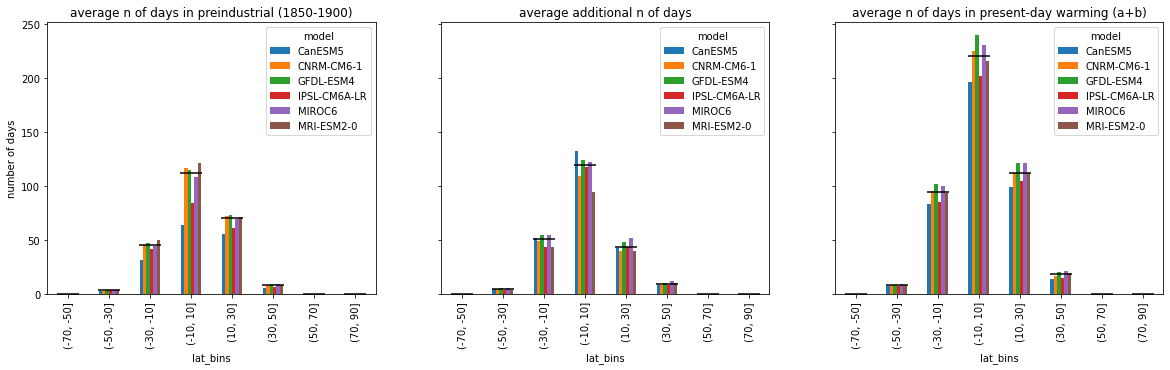

In [20]:
#higher p0, nAHD and p1 (nHAD+p0) in lower latitude

fig, axes = plt.subplots(1,3,figsize=(20,5),sharey=True)

ax=axes[0]
# per model per latitude band
da_p0_mean_lat.to_pandas().T.plot( kind='bar', ax=ax)
#multi-model median
ax.scatter(range(len(da_p0_mean_lat.lat_bins)),da_p0_mean_lat.to_pandas().T.median(axis=1), c='k', marker="_",s=500)
ax.set_title('average n of days in preindustrial (1850-1900)')
ax.set_ylabel('number of days')

ax=axes[1]
# per model per latitude band
da_nAHD_mean_lat.to_pandas().T.plot( kind='bar', ax=ax)
#multi-model median
ax.scatter(range(len(da_nAHD_mean_lat.lat_bins)),da_nAHD_mean_lat.to_pandas().T.median(axis=1), c='k', marker="_",s=500)
ax.set_title('average additional n of days')

ax=axes[2]
# per model per latitude band
da_p1_mean_lat.to_pandas().T.plot( kind='bar', ax=ax)
#multi-model median
ax.scatter(range(len(da_p1_mean_lat.lat_bins)),da_p1_mean_lat.to_pandas().T.median(axis=1), c='k', marker="_",s=500)
ax.set_title('average n of days in present-day warming (a+b)')



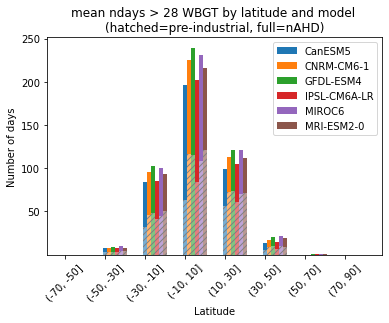

In [21]:
# set hatch color 
plt.rcParams["hatch.color"] = 'gray'

# Convert xarray DataArray to a pandas DataFrame
df_p0 = da_p0_mean_lat.to_pandas().T
df_nAHD = da_nAHD_mean_lat.to_pandas().T

# Get the list of column names
columns = df_p0.columns

# Set up the figure and axis
fig, ax = plt.subplots()

# Define width for each bar
bar_width = 0.1

# Define the index values for x-axis
index = df_p0.index.astype(str)

cmap = plt.cm.get_cmap('tab10')
colors = [cmap(i) for i in np.linspace(0, 1, 10)]

# Plot each column side by side
for i, column in enumerate(columns):
    ax.bar(np.arange(0,len(index)) + i * bar_width, df_nAHD[column], bar_width, label=column, bottom=df_p0[column],color=colors[i])
    if i == len(columns)-1:
        ax.bar(np.arange(0,len(index)) + i * bar_width, df_p0[column], bar_width,  color=colors[i],hatch="////",alpha=0.6) #label=column,
    else:
        ax.bar(np.arange(0,len(index)) + i * bar_width, df_p0[column], bar_width,  color=colors[i],hatch="////",alpha=0.6) #label=column,
    
# Set labels and title
ax.set_xlabel('Latitude')
ax.set_ylabel('Number of days')
ax.set_title('mean ndays > 28 WBGT by latitude and model \n(hatched=pre-industrial, full=nAHD)')
plt.xticks(ticks=np.arange(0,len(index)), labels=index, rotation=45)
ax.legend()

# Show plot
plt.show()


In [22]:

# data = da_p0_mean_lat
# pd.DataFrame(data={'median': data.to_pandas().T.median(axis=1), 
#                    'Q1':data.to_pandas().T.quantile(q=0.25,axis=1),
#                   'Q3':data.to_pandas().T.quantile(q=0.75,axis=1),
#                   'min':data.to_pandas().T.min(axis=1),
#                   'max':data.to_pandas().T.max(axis=1),
# })

In [23]:
# data = da_nAHD_mean_lat
# pd.DataFrame(data={'median': data.to_pandas().T.median(axis=1), 
#                    'Q1':data.to_pandas().T.quantile(q=0.25,axis=1),
#                   'Q3':data.to_pandas().T.quantile(q=0.75,axis=1),
#                   'min':data.to_pandas().T.min(axis=1),
#                   'max':data.to_pandas().T.max(axis=1),
# })

In [24]:
# data = da_p1_mean_lat
# pd.DataFrame(data={'median': data.to_pandas().T.median(axis=1), 
#                    'Q1':data.to_pandas().T.quantile(q=0.25,axis=1),
#                   'Q3':data.to_pandas().T.quantile(q=0.75,axis=1),
#                   'min':data.to_pandas().T.min(axis=1),
#                   'max':data.to_pandas().T.max(axis=1),
# })

### get symmetrical bands

In [25]:
da=da_p0
df = da_p0_mean_lat.to_pandas().T

weighted_sum = (da * landmask * 365 * cellarea).groupby_bins('lat', lat_bins[1:]).sum(dim=['lat','lon']).to_pandas()
total_area = (cellarea * landmask).groupby_bins('lat', lat_bins[1:]).sum(dim=['lat','lon']).to_pandas()
vals=(weighted_sum.iloc[:,[1]].values + weighted_sum.iloc[:,[5]].values) / (total_area.iloc[[1]].values + total_area.iloc[[5]].values)
df1=pd.DataFrame(data=vals.T, index=['(-50,-30](30,50]'], columns=df.columns)
vals=(weighted_sum.iloc[:,[2]].values + weighted_sum.iloc[:,[4]].values) / (total_area.iloc[[2]].values + total_area.iloc[[4]].values)
df2=pd.DataFrame(data=vals.T, index=['(-30,-10](10,30]'], columns=df.columns)

df_out = pd.concat([df,df1,df2],axis=0)

data = df_out
pd.DataFrame(data={'median': df_out.median(axis=1), 
                   'Q1':df_out.quantile(q=0.25,axis=1),
                  'Q3':df_out.quantile(q=0.75,axis=1),
                  'min':df_out.min(axis=1),
                  'max':df_out.max(axis=1),
})

,median,Q1,Q3,min,max
"(-70, -50]",0.000000,0.000000,0.000000,0.000000,0.000000
"(-50, -30]",3.489330,3.103352,3.857323,2.642582,4.023941
"(-30, -10]",45.412706,42.409866,47.251351,31.497580,50.338016
"(-10, 10]",111.927646,90.379763,116.056222,63.514273,120.879288
"(10, 30]",70.760884,63.419328,72.177733,56.062561,73.139297
"(30, 50]",8.568959,7.112182,9.312495,5.559369,9.496647
"(50, 70]",0.040566,0.022920,0.052976,0.015544,0.101686
"(70, 90]",0.001510,0.001219,0.003860,0.000238,0.005635
"(-50,-30](30,50]",7.824385,6.563760,8.485475,5.130637,8.668599
"(-30,-10](10,30]",60.559048,54.772813,62.372354,45.952760,62.844082


In [26]:
da=da_nAHD
df = da_nAHD_mean_lat.to_pandas().T

weighted_sum = (da * landmask * cellarea).groupby_bins('lat', lat_bins[1:]).sum(dim=['lat','lon']).to_pandas()
total_area = (cellarea * landmask).groupby_bins('lat', lat_bins[1:]).sum(dim=['lat','lon']).to_pandas()
vals=(weighted_sum.iloc[:,[1]].values + weighted_sum.iloc[:,[5]].values) / (total_area.iloc[[1]].values + total_area.iloc[[5]].values)
df1=pd.DataFrame(data=vals.T, index=['(-50,-30](30,50]'], columns=df.columns)
vals=(weighted_sum.iloc[:,[2]].values + weighted_sum.iloc[:,[4]].values) / (total_area.iloc[[2]].values + total_area.iloc[[4]].values)
df2=pd.DataFrame(data=vals.T, index=['(-30,-10](10,30]'], columns=df.columns)

df_out = pd.concat([df,df1,df2],axis=0)

data = df_out
pd.DataFrame(data={'median': df_out.median(axis=1), 
                   'Q1':df_out.quantile(q=0.25,axis=1),
                  'Q3':df_out.quantile(q=0.75,axis=1),
                  'min':df_out.min(axis=1),
                  'max':df_out.max(axis=1),
})

,median,Q1,Q3,min,max
"(-70, -50]",0.000000,0.000000,0.000000,0.000000,0.001880
"(-50, -30]",5.008620,4.398369,5.292820,3.975928,5.653162
"(-30, -10]",50.772564,45.366480,53.901761,43.182085,55.089096
"(-10, 10]",119.811471,111.212437,123.698543,94.700141,132.488410
"(10, 30]",43.338568,40.981838,46.843208,40.112954,51.516287
"(30, 50]",9.612384,8.564950,10.594493,8.202599,12.150422
"(50, 70]",0.141585,0.112862,0.165416,0.079615,0.285479
"(70, 90]",0.002293,0.001223,0.008138,0.000214,0.015490
"(-50,-30](30,50]",8.895662,8.027382,9.780368,7.581330,11.195404
"(-30,-10](10,30]",45.389659,43.787653,49.688835,41.464650,52.986689


In [27]:
da=da_p1
df = da_p1_mean_lat.to_pandas().T

weighted_sum = (da * landmask * 365 * cellarea).groupby_bins('lat', lat_bins[1:]).sum(dim=['lat','lon']).to_pandas()
total_area = (cellarea * landmask).groupby_bins('lat', lat_bins[1:]).sum(dim=['lat','lon']).to_pandas()
vals=(weighted_sum.iloc[:,[1]].values + weighted_sum.iloc[:,[5]].values) / (total_area.iloc[[1]].values + total_area.iloc[[5]].values)
df1=pd.DataFrame(data=vals.T, index=['(-50,-30](30,50]'], columns=df.columns)
vals=(weighted_sum.iloc[:,[2]].values + weighted_sum.iloc[:,[4]].values) / (total_area.iloc[[2]].values + total_area.iloc[[4]].values)
df2=pd.DataFrame(data=vals.T, index=['(-30,-10](10,30]'], columns=df.columns)

df_out = pd.concat([df,df1,df2],axis=0)

data = df_out
pd.DataFrame(data={'median': df_out.median(axis=1), 
                   'Q1':df_out.quantile(q=0.25,axis=1),
                  'Q3':df_out.quantile(q=0.75,axis=1),
                  'min':df_out.min(axis=1),
                  'max':df_out.max(axis=1),
})

,median,Q1,Q3,min,max
"(-70, -50]",0.000000,0.000000,0.000000,0.000000,0.001880
"(-50, -30]",8.239727,7.665665,8.660354,7.449398,9.624972
"(-30, -10]",94.444424,87.535783,98.886141,83.529863,102.241420
"(-10, 10]",220.491962,205.335629,229.313937,196.002683,239.505502
"(10, 30]",112.170277,106.555307,118.934206,99.199432,121.447360
"(30, 50]",18.181343,15.440786,19.921024,14.077097,21.628353
"(50, 70]",0.212873,0.156597,0.218392,0.095159,0.318447
"(70, 90]",0.004511,0.003449,0.009728,0.001193,0.021125
"(-50,-30](30,50]",16.720047,14.297938,18.265844,13.102906,19.864003
"(-30,-10](10,30]",104.875142,98.727757,110.843947,92.750568,113.328970


## Check Delhi + Calcutta

In [28]:
lat_d, lon_d = 28,77
lat_c, lon_c = 22,88

nAHD_delhi = da_nAHD.sel(lat=lat_d, lon=lon_d, method='nearest')
nAHD_calcutta = da_nAHD.sel(lat=lat_c, lon=lon_c, method='nearest')

In [29]:
print('Delhi nAHD present-day warming')
pd.DataFrame(nAHD_delhi.to_pandas(), columns=['days']).applymap(format_large_numbers)

Delhi nAHD present-day warming


,days
model,
CanESM5,40.9
CNRM-CM6-1,19.0
GFDL-ESM4,29.4
IPSL-CM6A-LR,32.7
MIROC6,22.6
MRI-ESM2-0,13.7


In [30]:
print('Calcutta nAHD present-day warming')
pd.DataFrame(nAHD_calcutta.to_pandas(), columns=['days']).applymap(format_large_numbers)

Calcutta nAHD present-day warming


,days
model,
CanESM5,46.7
CNRM-CM6-1,16.6
GFDL-ESM4,24.3
IPSL-CM6A-LR,35.2
MIROC6,16.6
MRI-ESM2-0,18.8


## combine with demographics

save thiss !!! and just open it as ncfile!

In [15]:
d_countries = preprocess_all_country_population_data()
gs_population_global = get_gridscale_population_global( 
    d_countries,
    startyear=2023,
    endyear=None,
    save=False # change where this gets saved !!!! now its in package folder
)

interpolating cohort sizes per country
after interpolation and mean-preserving correction there are some neg numbers in 10, Azerbaijan, setting them to zero
after interpolation and mean-preserving correction there are some neg numbers in 98, Libya, setting them to zero
after interpolation and mean-preserving correction there are some neg numbers in 136, Papua New Guinea, setting them to zero
Aruba small, population not calculated
Antigua and Barbuda small, population not calculated
Bahrain small, population not calculated
Barbados small, population not calculated
Federated States of Micronesia small, population not calculated
Grenada small, population not calculated
Guam small, population not calculated
Saint Lucia small, population not calculated
Macao small, population not calculated
Maldives small, population not calculated
Malta small, population not calculated
Singapore small, population not calculated
Tonga small, population not calculated
calculating gridscale population per cou

In [16]:
#nAHD : number of people and proportion of age group living through at least x additional days 

da_n_people_ndays, da_prop_people_ndays = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, 
                                                                                          GCMs, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = [1,5,10,20,50])


da_n_people_1y, da_prop_people_1y = calc_number_proportion_people_atleastxdays_1yr(gs_population_global, 
                                                                                     GCMs, 
                                                                                     da_nAHD, 
                                                                                     x_hot_days = [1, 5, 10, 20, 50], 
                                                                                     ages_values=range(0,100),
                                                                                     grouped = False,
                                                                                     size_win = None
                                                                                    )


In [17]:
#nAHD : average per capita additional days and people x additional days 

da_nAHD_percapita_peopledays_18y = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                           GCMs, 
                                           da_nAHD,
                                           x_hot_days = [1, 5, 10, 20, 50], 
                                           ages_values=range(0,100),
                                           grouped = True,
                                           size_win = 18
                                           )

da_nAHD_percapita_peopledays_10y = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                           GCMs, 
                                           da_nAHD,
                                           x_hot_days = [1, 5, 10, 20, 50], 
                                           ages_values=range(0,100),
                                           grouped = True,
                                           size_win = 10
                                           )

da_nAHD_percapita_peopledays_1y = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                           GCMs, 
                                           da_nAHD,
                                           x_hot_days = [1, 5, 10, 20, 50], 
                                           ages_values=range(0,100),
                                           grouped = False,
                                           size_win = None
                                           )

In [34]:
# absolute number of days crossing threshold (not just additional)

da_totaldays_percapita_peopledays_18y = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                           GCMs, 
                                           da_p1 * 365,
                                           x_hot_days = [1, 5, 10, 20, 50], 
                                           ages_values=range(0,100),
                                           grouped = True,
                                           size_win = 18
                                           )

da_totaldays_percapita_peopledays_10y = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                           GCMs, 
                                           da_p1 * 365,
                                           x_hot_days = [1, 5, 10, 20, 50], 
                                           ages_values=range(0,100),
                                           grouped = True,
                                           size_win = 10
                                           )
da_totaldays_percapita_peopledays_1y = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                           GCMs, 
                                           da_p1 * 365,
                                           x_hot_days = [1, 5, 10, 20, 50], 
                                           ages_values=range(0,100),
                                           grouped = False,
                                           size_win = None
                                           )

da_n_people_1y_totaldays, da_prop_people_1y_totaldays = calc_number_proportion_people_atleastxdays_1yr(gs_population_global, 
                                                                                     GCMs, 
                                                                                     da_p1 * 365, 
                                                                                     x_hot_days = [1, 5, 10, 20, 50], 
                                                                                     ages_values=range(0,100),
                                                                                     grouped = False,
                                                                                     size_win = None
                                                                                    )

## Do some plots

### 1. Number of people and proportion of age group living through x additional days crossing WBGT28

Text(0.5, 1.0, 'number of people experiencing at least n attributable hot-humid days (>WBGT28) in 2022')

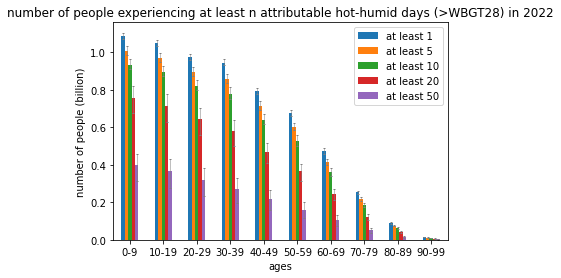

In [35]:
fig, ax = plt.subplots()
plot_barplot_n_prop_people_atleastx_modelmean(da_n_people_ndays, unit=1e9, year=2022, ax=ax, proportion=False)
plt.legend(labels = [f'at least {x}' for x in  [1, 5, 10, 20, 50]])
ax.set_title(f'number of people experiencing at least n attributable hot-humid days (>WBGT28) in 2022')

#plt.savefig(os.path.join(figdir,'n_atleastx_2022_10yr.png'),dpi=300)

Text(0.5, 1.0, 'proportion of age group experiencing at least n attributable hot-humid days (>WBGT28) in 2022')

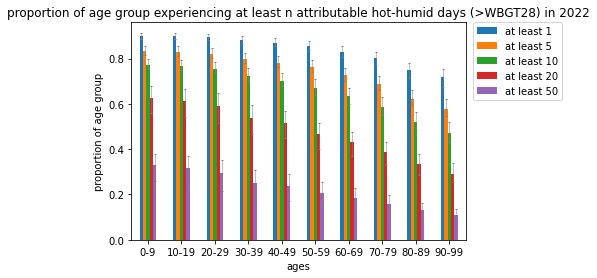

In [36]:
fig, ax = plt.subplots()
plot_barplot_n_prop_people_atleastx_modelmean(da_prop_people_ndays, unit=1, year=2022, ax=ax, proportion=True)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, labels = [f'at least {x}' for x in  [1, 5, 10, 20, 50]])
ax.set_title(f'proportion of age group experiencing at least n attributable hot-humid days (>WBGT28) in 2022')

#plt.savefig(os.path.join(figdir,'prop_atleastx_2022_10yr.png'),dpi=300)

### 2. Per capita additional days per age group

In [37]:
df_percapitadays_10y = da_nAHD_percapita_peopledays_10y.sel(features='per_capita_days').to_pandas().T
#df_percapitadays_10y

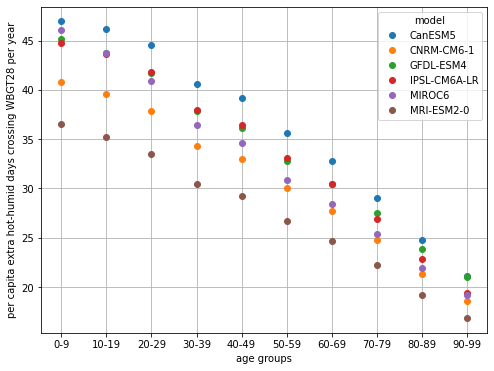

In [38]:
fig, ax = plt.subplots(figsize=(8,6))
df_plot = df_percapitadays_10y
df_plot.plot(marker='o',linestyle='None', ax=ax)
plt.ylabel('per capita extra hot-humid days crossing WBGT28 per year')
plt.xlabel('age groups')
plt.xticks(df_plot.index);
plt.grid()
ax.set_xticks(ticks=ax.get_xticks(), labels=[f'{x}-{x+9}' for x in df_plot.index], rotation='horizontal');


In [39]:
df_percapitadays_18y = da_nAHD_percapita_peopledays_18y.sel(features='per_capita_days').to_pandas().T
df_percapitadays_18y

model,CanESM5,CNRM-CM6-1,GFDL-ESM4,IPSL-CM6A-LR,MIROC6,MRI-ESM2-0
age_ranges,,,,,,
0,46.603871,40.298436,44.599867,44.333221,45.182210,35.977471
18,43.522163,36.913998,40.718901,40.789187,39.772823,32.702568
36,38.844376,32.758791,35.886657,36.163765,34.324223,29.079472
54,33.532820,28.325434,30.993961,31.114588,28.989665,25.166794
72,27.279771,23.378658,26.002646,25.252822,24.005005,20.993080
90,21.112949,18.592797,21.039438,19.382330,19.219898,16.856929


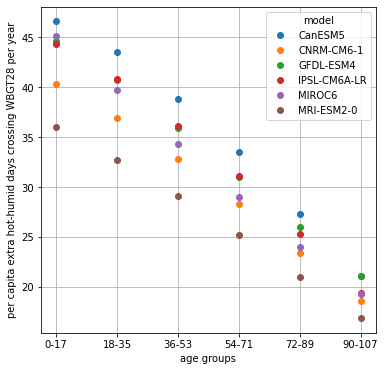

In [40]:
fig, ax = plt.subplots(figsize=(6,6))
df_plot = df_percapitadays_18y
df_plot.plot(marker='o',linestyle='None', ax=ax)
plt.ylabel('per capita extra hot-humid days crossing WBGT28 per year')
plt.xlabel('age groups')
plt.xticks(df_plot.index);
plt.grid()
ax.set_xticks(ticks=ax.get_xticks(), labels=[f'{x}-{x+17}' for x in df_plot.index], rotation='horizontal');

#plt.savefig(os.path.join(figdir,'percapita_hotdays_18y_TX99.png'), dpi=300, transparent=False)

In [41]:
df_percapitadays_18y.median(axis=1)

age_ranges
0     44.466544
18    40.245862
36    35.105440
54    29.991813
72    24.628913
90    19.301114
dtype: float64

In [42]:
df_percapitadays_18y.mean(axis=1)

age_ranges
0     42.832513
18    39.069940
36    34.509547
54    29.687210
72    24.485330
90    19.367390
dtype: float64

### 3. summary results children v. adults 

TODO:
- make this a fxn and check it !
- check i am not only considering places where increase 

In [43]:
# number of children versus number of adults living in places where increase 
ch_start = 0
ch_end = 9
ad_start = 60
ad_end = 69 

df = da_n_people_1y.sel(features='n_whrincr').to_pandas().T

children_whr_increase = df.iloc[ch_start:ch_end+1].sum(axis=0)
adults_whr_increase = df.iloc[ad_start:ad_end+1].sum(axis=0)

In [44]:
df = da_nAHD_percapita_peopledays_1y.sel(features='people_days').to_pandas().T

children_peopledays = df.iloc[ch_start:ch_end+1].sum(axis=0) 
adults_peopledays = df.iloc[ad_start:ad_end+1].sum(axis=0)

In [45]:
df_values = da_nAHD_percapita_peopledays_1y.sel(features='per_capita_days').to_pandas().T
df_npeople = da_nAHD_percapita_peopledays_1y.sel(features='n_people').to_pandas().T

children_percapita =  calc_weighted_average(df_values, df_npeople, ch_start, ch_end+1)
adults_percapita = calc_weighted_average(df_values, df_npeople, ad_start, ad_end+1)

# note! check i am not only considering places where increase 

note: loc 10 is excluded
note: loc 70 is excluded


In [46]:
df_summary = pd.concat([children_whr_increase,
           adults_whr_increase,
          children_peopledays,
          adults_peopledays,
          children_percapita,
          adults_percapita], axis=1,
         keys= ['children_whr_increase',
           'adults_whr_increase',
          'children_peopledays',
          'adults_peopledays',
          'children_percapita',
          'adults_percapita'])

In [47]:

df_summary.applymap(format_large_numbers)

# this gives the same as above, but different to my old function - check why !! 
# if you do 0-18 included and 40-58 included number of people is the same but people x days and per capita days are different
# see attr-hw-isimip3b-TX99-exposure-dev0 & understand why 

,children_whr_increase,adults_whr_increase,children_peopledays,adults_peopledays,children_percapita,adults_percapita
model,,,,,,
CanESM5,1.2B,532.9M,56.8B,18.7B,46.9,32.8
CNRM-CM6-1,1.2B,528.5M,49.4B,15.9B,40.8,27.8
GFDL-ESM4,1.2B,538.8M,54.6B,17.4B,45.2,30.4
IPSL-CM6A-LR,1.2B,540.7M,54.2B,17.4B,44.8,30.4
MIROC6,1.2B,548.3M,55.8B,16.2B,46.1,28.4
MRI-ESM2-0,1.2B,544.2M,44.1B,14.1B,36.5,24.7


In [48]:
pd.concat([df_summary, pd.DataFrame(df_summary.median(axis=0)).rename(columns={0:'median'}).T]).applymap(format_large_numbers)

,children_whr_increase,adults_whr_increase,children_peopledays,adults_peopledays,children_percapita,adults_percapita
CanESM5,1.2B,532.9M,56.8B,18.7B,46.9,32.8
CNRM-CM6-1,1.2B,528.5M,49.4B,15.9B,40.8,27.8
GFDL-ESM4,1.2B,538.8M,54.6B,17.4B,45.2,30.4
IPSL-CM6A-LR,1.2B,540.7M,54.2B,17.4B,44.8,30.4
MIROC6,1.2B,548.3M,55.8B,16.2B,46.1,28.4
MRI-ESM2-0,1.2B,544.2M,44.1B,14.1B,36.5,24.7
median,1.2B,539.7M,54.4B,16.8B,45.0,29.4


In [49]:
data=df_summary
pd.DataFrame(data={'median': df_summary.median(axis=0), 
                   'Q1':df_summary.quantile(q=0.25,axis=0),
                  'Q3':df_summary.quantile(q=0.75,axis=0),
                  'min':df_summary.min(axis=0),
                  'max':df_summary.max(axis=0),
}).applymap(format_large_numbers)

# instead of whr incr give greater than 5, 10,15,20... 

,median,Q1,Q3,min,max
children_whr_increase,1.2B,1.2B,1.2B,1.2B,1.2B
adults_whr_increase,539.7M,534.4M,543.3M,528.5M,548.3M
children_peopledays,54.4B,50.6B,55.5B,44.1B,56.8B
adults_peopledays,16.8B,15.9B,17.4B,14.1B,18.7B
children_percapita,45.0,41.8,45.9,36.5,46.9
adults_percapita,29.4,27.9,30.4,24.7,32.8


### 4. distribution of people

In [18]:
def ecdf(data, num_bins=10000):
    """
    Compute the empirical cumulative distribution function (ECDF) for a given data array using bins.
    
    Parameters:
    - data (array-like): The input data array.
    - num_bins (int): The number of bins to use for histogram.
    
    Returns:
    - x (array-like): The sorted data points (bin centers).
    - y (array-like): The ECDF values for the sorted data points.
    """
    # Compute histogram of data
    counts, bin_edges = np.histogram(data, bins=num_bins)
    
    # Compute the cumulative counts
    cumulative_counts = np.cumsum(counts)
    
    # Normalize cumulative counts to get ECDF values
    y = cumulative_counts / cumulative_counts[-1]
    
    # Use the bin centers for the x values
    x = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    return x, y

In [95]:
# da_pop = gs_population_global.sel(ages=slice(0,9)).sum(dim='ages') #.values #.flatten().astype(int)

# GCM=GCMs[0]
# da_nAHD_sel = da_nAHD.sel(model=GCM) #.values.flatten()

# population_da_aligned, da_nAHD_da_aligned = xr.align(da_pop, da_nAHD_sel, join='outer', fill_value=0)

# arr_nAHD = da_nAHD_da_aligned.values.flatten()
# arr_pop = population_da_aligned.values.flatten().astype(int)

# arr_repeated = np.repeat(arr_nAHD, arr_pop)

# x, y = ecdf(arr_repeated)

In [94]:
# x_models_young = []
# y_models_young = []

# da_pop = gs_population_global.sel(ages=slice(0,9)).sum(dim='ages') 
# population_da_aligned, da_nAHD_da_aligned = xr.align(da_pop, da_nAHD.isel(model=0), join='outer', fill_value=0)
# arr_pop = population_da_aligned.values.flatten().astype(int)

# for GCM in GCMs:
#     da_nAHD_sel = da_nAHD.sel(model=GCM) 
#     arr_nAHD = da_nAHD_sel.values.flatten()
    
#     arr_repeated = np.repeat(arr_nAHD, arr_pop)
    
#     x, y = ecdf(arr_repeated)
    
#     if len(x_models_young) == 0:
#         x_models_young = x
#         y_models_young = y
#     else:
#         x_models_young = np.vstack((x_models_young, x))
#         y_models_young = np.vstack((y_models_young, y))

    
# # THIS IS WRONG ! 


In [19]:
x_models_young = []
y_models_young = []

da_pop = gs_population_global.sel(ages=slice(0,9)).sum(dim='ages') 


for GCM in GCMs:
    da_nAHD_sel = da_nAHD.sel(model=GCM) 
    
    population_da_aligned, da_nAHD_da_aligned = xr.align(da_pop, da_nAHD_sel, join='outer', fill_value=0)
    
    arr_pop = population_da_aligned.values.flatten().astype(int)
    arr_nAHD = da_nAHD_da_aligned.values.flatten()
    
    arr_repeated = np.repeat(arr_nAHD, arr_pop)
    
    x, y = ecdf(arr_repeated)
    
    if len(x_models_young) == 0:
        x_models_young = x
        y_models_young = y
    else:
        x_models_young = np.vstack((x_models_young, x))
        y_models_young = np.vstack((y_models_young, y))

In [20]:
# da_pop = gs_population_global.sel(ages=slice(60,69)).sum(dim='ages') #.values #.flatten().astype(int)

# # GCM=GCMs[0]
# # da_nAHD_sel = da_nAHD.sel(model=GCM) #.values.flatten()

# population_da_aligned, da_nAHD_da_aligned = xr.align(da_pop, da_nAHD_sel, join='outer', fill_value=0)

# arr_nAHD = da_nAHD_da_aligned.values.flatten()
# arr_pop = population_da_aligned.values.flatten().astype(int)

# arr_repeated = np.repeat(arr_nAHD, arr_pop)

# x_old, y_old = ecdf(arr_repeated)

In [21]:
x_models_old = []
y_models_old = []

da_pop = gs_population_global.sel(ages=slice(60,69)).sum(dim='ages') 


for GCM in GCMs:
    da_nAHD_sel = da_nAHD.sel(model=GCM) 
    
    population_da_aligned, da_nAHD_da_aligned = xr.align(da_pop, da_nAHD_sel, join='outer', fill_value=0)
    
    arr_pop = population_da_aligned.values.flatten().astype(int)
    arr_nAHD = da_nAHD_da_aligned.values.flatten()
    
    arr_repeated = np.repeat(arr_nAHD, arr_pop)
    
    x, y = ecdf(arr_repeated)
    
    if len(x_models_old) == 0:
        x_models_old = x
        y_models_old = y
    else:
        x_models_old = np.vstack((x_models_old, x))
        y_models_old = np.vstack((y_models_old, y))

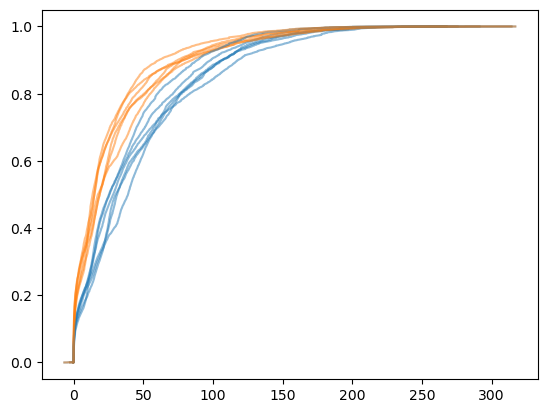

In [23]:
fig,ax = plt.subplots()
for i in range(len(GCMs)):
    ax.plot(x_models_young[i,:], y_models_young[i,:], c='C0', alpha=0.5)
    ax.plot(x_models_old[i,:], y_models_old[i,:], c='C1', alpha=0.5)

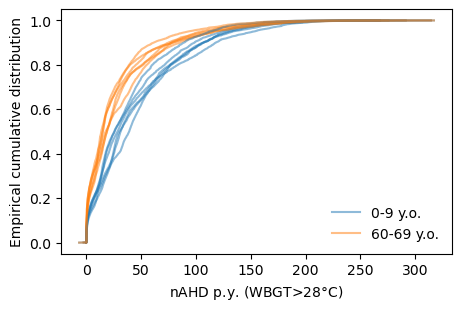

In [43]:
fig,ax = plt.subplots(figsize=(4.5,3),facecolor='none',layout='constrained')

for i in range(len(GCMs)):
    if i == 0:
        ax.plot(x_models_young[i,:], y_models_young[i,:], c='C0', alpha=0.5, label='0-9 y.o.')
        ax.plot(x_models_old[i,:], y_models_old[i,:], c='C1', alpha=0.5, label='60-69 y.o.')
    else:
        ax.plot(x_models_young[i,:], y_models_young[i,:], c='C0', alpha=0.5)
        ax.plot(x_models_old[i,:], y_models_old[i,:], c='C1', alpha=0.5)

plt.xlabel('nAHD p.y. (WBGT>28$\degree$C)')
plt.ylabel('Empirical cumulative distribution')
plt.legend( frameon=False)

#plt.savefig(os.path.join(figdir,'CDF_agegroup.png'),dpi=300,transparent=True)

In [26]:
x_models_young.max()

328.64996

In [27]:
x_models_old.max()

328.64996

In [129]:
# Calculate the absolute differences with the target value
differences = np.abs(y_models_old[0] - 0.95)
# Find the index of the minimum difference
closest_index = np.argmin(differences)
# Find the corresponding value in array1
result = x_models_old[:,closest_index]

print(result)
print(np.median(result))

[115.52548   97.765854 112.983765  98.80185  106.16458   96.26442 ]
102.483215


In [123]:
# Calculate the absolute differences with the target value
differences = np.abs(y_models_old[0] - 0.9)
# Find the index of the minimum difference
closest_index = np.argmin(differences)
# Find the corresponding value in array1
result = x_models_old[:,closest_index]

np.median(result)

74.792206

In [128]:
# Calculate the absolute differences with the target value
differences = np.abs(y_models_young[0] - 0.95)
# Find the index of the minimum difference
closest_index = np.argmin(differences)
# Find the corresponding value in array1
result = x_models_young[:,closest_index]

print(result)
print(np.median(result))

[133.22275  112.78848  130.66287  113.980255 122.42378  112.01152 ]
118.20202


In [124]:
# Calculate the absolute differences with the target value
differences = np.abs(y_models_young[0] - 0.9)
# Find the index of the minimum difference
closest_index = np.argmin(differences)
# Find the corresponding value in array1
result = x_models_young[:,closest_index]

np.median(result)

94.68016

In [125]:
# Calculate the absolute differences with the target value
differences = np.abs(y_models_young[0] - 0.99)
# Find the index of the minimum difference
closest_index = np.argmin(differences)
# Find the corresponding value in array1
result = x_models_young[:,closest_index]

np.median(result)

167.41483

In [126]:
# Calculate the absolute differences with the target value
differences = np.abs(y_models_young[0] - 0.999)
# Find the index of the minimum difference
closest_index = np.argmin(differences)
# Find the corresponding value in array1
result = x_models_young[:,closest_index]

np.median(result)

209.3648

In [127]:
# Calculate the absolute differences with the target value
differences = np.abs(y_models_young[0] - 0.9999)
# Find the index of the minimum difference
closest_index = np.argmin(differences)
# Find the corresponding value in array1
result = x_models_young[:,closest_index]

np.median(result)

268.64526

In [132]:
# Calculate the absolute differences with the target value
differences = np.abs(y_models_young[0] - 0.5)
# Find the index of the minimum difference
closest_index = np.argmin(differences)
# Find the corresponding value in array1
result = x_models_young[:,closest_index]

print(result)
print(np.median(result))

[38.869083 32.69475  36.40605  33.05597  35.73718  28.055237]
34.396576


In [133]:
# Calculate the absolute differences with the target value
differences = np.abs(y_models_young[0] - 0.1)
# Find the index of the minimum difference
closest_index = np.argmin(differences)
# Find the corresponding value in array1
result = x_models_young[:,closest_index]

print(result)
print(np.median(result))

[ 0.6836026   0.2803493  -1.7402354   0.30543494  0.65459865 -5.9223633 ]
0.29289213


In [134]:
# Calculate the absolute differences with the target value
differences = np.abs(y_models_young[0] - 0.2)
# Find the index of the minimum difference
closest_index = np.argmin(differences)
# Find the corresponding value in array1
result = x_models_young[:,closest_index]

print(result)
print(np.median(result))

[ 6.899843    5.5571127   4.469625    5.636917    6.3657165  -0.39112598]
5.597015


### 4. total days, not only attributable, in present-day

In [ ]:
df_percapitadays_10y_tot = da_totaldays_percapita_peopledays_10y.sel(features='per_capita_days').to_pandas().T
#df_percapitadays_10y

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
df_plot = df_percapitadays_10y_tot
df_plot.plot(marker='o',linestyle='None', ax=ax)
plt.ylabel('per capita total hot-humid days crossing WBGT28 per year')
plt.xlabel('age groups')
plt.xticks(df_plot.index);
plt.grid()
ax.set_xticks(ticks=ax.get_xticks(), labels=[f'{x}-{x+9}' for x in df_plot.index], rotation='horizontal');


In [ ]:
df_percapitadays_18y_tot = da_totaldays_percapita_peopledays_18y.sel(features='per_capita_days').to_pandas().T
df_percapitadays_18y_tot

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
df_plot = df_percapitadays_18y_tot
df_plot.plot(marker='o',linestyle='None', ax=ax)
plt.ylabel('per capita total hot-humid days crossing WBGT28 per year')
plt.xlabel('age groups')
plt.xticks(df_plot.index);
plt.grid()
ax.set_xticks(ticks=ax.get_xticks(), labels=[f'{x}-{x+17}' for x in df_plot.index], rotation='horizontal');

#plt.savefig(os.path.join(figdir,'percapita_hotdays_18y_TX99.png'), dpi=300, transparent=False)

In [ ]:
df_percapitadays_18y_tot.median(axis=1)

In [ ]:
df_percapitadays_18y_tot.mean(axis=1)

### 5. summary results total days

In [ ]:
da_n_people_1y.isel(model=0).to_pandas() # nAHD

In [ ]:
da_n_people_1y_totaldays.isel(model=0).to_pandas() #totaldays

In [ ]:
# number of children versus number of adults living in places where there are days crossing threshold 

# TODO: make this a fxn !!! 
ch_start = 0
ch_end = 9+1
ad_start = 60
ad_end = 69+1

df = da_n_people_1y_totaldays.sel(features='n_whrincr').to_pandas().T # its not actually an increase here

children_whr_increase = df.iloc[ch_start:ch_end].sum(axis=0)
adults_whr_increase = df.iloc[ad_start:ad_end].sum(axis=0)

df = da_totaldays_percapita_peopledays_1y.sel(features='people_days').to_pandas().T

children_peopledays = df.iloc[ch_start:ch_end].sum(axis=0) 
adults_peopledays = df.iloc[ad_start:ad_end].sum(axis=0)

df_values = da_totaldays_percapita_peopledays_1y.sel(features='per_capita_days').to_pandas().T
df_npeople = da_totaldays_percapita_peopledays_1y.sel(features='n_people').to_pandas().T

children_percapita =  calc_weighted_average(df_values, df_npeople, 0, ch_end)
adults_percapita = calc_weighted_average(df_values, df_npeople, ad_end-18, ad_end)

# note! check i am not only considering places where increase 

df_summary = pd.concat([children_whr_increase,
           adults_whr_increase,
          children_peopledays,
          adults_peopledays,
          children_percapita,
          adults_percapita], axis=1,
         keys= ['children_whr_increase',
           'adults_whr_increase',
          'children_peopledays',
          'adults_peopledays',
          'children_percapita',
          'adults_percapita'])

In [ ]:
df_summary.applymap(format_large_numbers)

# different to my old function - check why !! 
# if you do 0-18 included and 40-58 included number of people is the same but people x days and per capita days are different
# see attr-hw-isimip3b-TX99-exposure-dev0 & understand why 

In [ ]:
pd.DataFrame(df_summary.median(axis=0), columns=['median']).applymap(format_large_numbers)

### total days, population CDda_p1F [MAKE A FUNCTION !!]

In [162]:
x_models_young = []
y_models_young = []

da_pop = gs_population_global.sel(ages=slice(0,9)).sum(dim='ages') 


for GCM in GCMs:
    da_nAHD_sel = da_p1.sel(model=GCM) * 365 # RENAME THIS !! 
    
    population_da_aligned, da_nAHD_da_aligned = xr.align(da_pop, da_nAHD_sel, join='outer', fill_value=0)
    
    arr_pop = population_da_aligned.values.flatten().astype(int)
    arr_nAHD = da_nAHD_da_aligned.values.flatten()
    
    arr_repeated = np.repeat(arr_nAHD, arr_pop)
    
    x, y = ecdf(arr_repeated)
    
    if len(x_models_young) == 0:
        x_models_young = x
        y_models_young = y
    else:
        x_models_young = np.vstack((x_models_young, x))
        y_models_young = np.vstack((y_models_young, y))

In [163]:
x_models_old = []
y_models_old = []

da_pop = gs_population_global.sel(ages=slice(60,69)).sum(dim='ages') 


for GCM in GCMs:
    da_nAHD_sel = da_p1.sel(model=GCM) * 365 # RENAME THIS !! 
    
    population_da_aligned, da_nAHD_da_aligned = xr.align(da_pop, da_nAHD_sel, join='outer', fill_value=0)
    
    arr_pop = population_da_aligned.values.flatten().astype(int)
    arr_nAHD = da_nAHD_da_aligned.values.flatten()
    
    arr_repeated = np.repeat(arr_nAHD, arr_pop)
    
    x, y = ecdf(arr_repeated)
    
    if len(x_models_old) == 0:
        x_models_old = x
        y_models_old = y
    else:
        x_models_old = np.vstack((x_models_old, x))
        y_models_old = np.vstack((y_models_old, y))

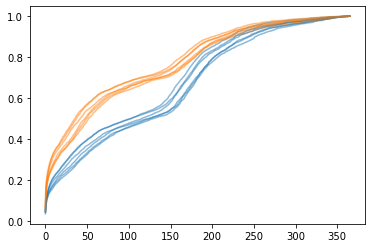

In [164]:
fig,ax = plt.subplots()
for i in range(len(GCMs)):
    ax.plot(x_models_young[i,:], y_models_young[i,:], c='C0', alpha=0.5)
    ax.plot(x_models_old[i,:], y_models_old[i,:], c='C1', alpha=0.5)

In [165]:
# Calculate the absolute differences with the target value
differences = np.abs(y_models_old[0] - 0.95)
# Find the index of the minimum difference
closest_index = np.argmin(differences)
# Find the corresponding value in array1
result = x_models_old[:,closest_index]

print(result)
print(np.median(result))

[237.21011 237.21011 237.21011 237.21011 237.21011 237.1235 ]
237.21011


In [166]:
# Calculate the absolute differences with the target value
differences = np.abs(y_models_old[0] - 0.9)
# Find the index of the minimum difference
closest_index = np.argmin(differences)
# Find the corresponding value in array1
result = x_models_old[:,closest_index]

np.median(result)

200.96892

In [167]:
# Calculate the absolute differences with the target value
differences = np.abs(y_models_young[0] - 0.95)
# Find the index of the minimum difference
closest_index = np.argmin(differences)
# Find the corresponding value in array1
result = x_models_young[:,closest_index]

print(result)
print(np.median(result))

[246.73575 246.73575 246.73575 246.73575 246.73575 246.64563]
246.73575


In [168]:
# Calculate the absolute differences with the target value
differences = np.abs(y_models_young[0] - 0.9)
# Find the index of the minimum difference
closest_index = np.argmin(differences)
# Find the corresponding value in array1
result = x_models_young[:,closest_index]


print(result)
print(np.median(result))

[222.0275  222.0275  222.0275  222.0275  222.0275  221.94641]
222.0275


In [169]:
# Calculate the absolute differences with the target value
differences = np.abs(y_models_young[0] - 0.99)
# Find the index of the minimum difference
closest_index = np.argmin(differences)
# Find the corresponding value in array1
result = x_models_young[:,closest_index]

print(result)
print(np.median(result))

[317.64877 317.64877 317.64877 317.64877 317.64877 317.53278]
317.64877


In [170]:
# Calculate the absolute differences with the target value
differences = np.abs(y_models_young[0] - 0.999)
# Find the index of the minimum difference
closest_index = np.argmin(differences)
# Find the corresponding value in array1
result = x_models_young[:,closest_index]

np.median(result)

356.9557

In [171]:
# Calculate the absolute differences with the target value
differences = np.abs(y_models_young[0] - 0.9999)
# Find the index of the minimum difference
closest_index = np.argmin(differences)
# Find the corresponding value in array1
result = x_models_young[:,closest_index]

np.median(result)

364.21854

In [172]:
# Calculate the absolute differences with the target value
differences = np.abs(y_models_young[0] - 0.5)
# Find the index of the minimum difference
closest_index = np.argmin(differences)
# Find the corresponding value in array1
result = x_models_young[:,closest_index]

print(result)
print(np.median(result))

[102.79288 102.79288 102.79288 102.79288 102.79288 102.75534]
102.79288


In [173]:
# Calculate the absolute differences with the target value
differences = np.abs(y_models_young[0] - 0.1)
# Find the index of the minimum difference
closest_index = np.argmin(differences)
# Find the corresponding value in array1
result = x_models_young[:,closest_index]

print(result)
print(np.median(result))

[0.71168506 0.71168506 0.71168506 0.71168506 0.71168506 0.7114252 ]
0.71168506


In [147]:
# Calculate the absolute differences with the target value
differences = np.abs(y_models_young[0] - 0.2)
# Find the index of the minimum difference
closest_index = np.argmin(differences)
# Find the corresponding value in array1
result = x_models_young[:,closest_index]

print(result)
print(np.median(result))

[7.9745226 7.9745226 7.9745226 7.9745226 7.9745226 7.9716105]
7.9745226


In [153]:
closest_index

8703